# Car Price Prediction Report

This report summarizes the process and findings of building a model to predict car selling prices based on a given dataset.



In [ ]:
!pip install -U langchain-google-genai

In [2]:
import pandas as pd
import numpy as np
import sklearn

## 1. Data Loading and Exploration

- The dataset was loaded using pandas from a CSV file named `car.csv`.
- Initial exploration was performed using `df.head()`, `df.info()`, `df.isnull().sum()`, and `df.describe()`.

In [3]:
df = pd.read_csv('car.csv')

## **setup my LLM**

In [41]:
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langchain.chat_models import init_chat_model
import os
from dotenv import load_dotenv

#importing gemini
load_dotenv()
api_key = os.environ.get("gemini_api_key")

model = init_chat_model(
    "google_genai:gemini-2.0-flash",
    temperature=0,
    api_key=api_key
)

system_prompt = """
You are a Machine learning Engineer and you're currently assistanting me on the task.
YOU'll do exactly what human message says."""
system_prompt = SystemMessage(content=system_prompt)

conversation = [system_prompt]

def ask_llm(user_input: str):
    global conversation
    conversation.append(HumanMessage(content=user_input))
    response = model(conversation)

    conversation.append(response)

    return response.content

# human message in each cells



## 2. Understanding the Dataset with **LLM**

To get a better understanding of the dataset columns and their potential relevance for car price prediction, we utilized a Large Language Model (LLM).

- A human message containing the column names and a request to explain the dataset was passed to the LLM.
- The LLM's response provided insights into the meaning of each column and how they might influence the car selling price.

This process helped in identifying important features and potential preprocessing steps before model building.

In [5]:
human_prompt = f""" {df} Explain what each column in this car dataset likely means based on its name and data type in sorted format and tell me the best ways to clean up messy parts
"""
print(ask_llm(human_prompt))

C:\Users\rmcsh\AppData\Local\Temp\ipykernel_15468\2698796064.py:26: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = model(conversation)


Okay, I will explain each column in the car dataset, sorted alphabetically, and suggest ways to clean up potential messy parts.

**Column Explanations and Data Cleaning Strategies**

Here's a breakdown of each column:

1.  **`engine`**:
    *   **Meaning:** Engine displacement of the car, likely in cubic centimeters (cc).
    *   **Data Type:** Numerical (float).
    *   **Potential Issues:**
        *   **Missing Values:**  Handle with imputation (mean, median, or model-based).
        *   **Outliers:** Check for unusually large or small engine sizes that might be errors.
        *   **Units:** Ensure all values are in the same unit (cc).
    *   **Cleaning:**
        *   `df['engine'].fillna(df['engine'].median(), inplace=True)` #Impute missing values with median
        *   `Q1 = df['engine'].quantile(0.25)` #Remove outliers
        *   `Q3 = df['engine'].quantile(0.75)`
        *   `IQR = Q3 - Q1`
        *   `lower_bound = Q1 - 1.5 * IQR`
        *   `upper_bound = Q3 + 1.5 * IQR`

In [6]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8128 non-null   object 
 1   year                8128 non-null   int64  
 2   selling_price       8128 non-null   int64  
 3   km_driven           8128 non-null   int64  
 4   fuel                8128 non-null   object 
 5   seller_type         8128 non-null   object 
 6   transmission        8128 non-null   object 
 7   owner               8128 non-null   object 
 8   mileage(km/ltr/kg)  7907 non-null   float64
 9   engine              7907 non-null   float64
 10  max_power           7913 non-null   object 
 11  seats               7907 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 762.1+ KB


In [8]:
df.isnull().sum()

name                    0
year                    0
selling_price           0
km_driven               0
fuel                    0
seller_type             0
transmission            0
owner                   0
mileage(km/ltr/kg)    221
engine                221
max_power             215
seats                 221
dtype: int64

In [9]:
df.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000,7907.000000,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,19.418783,1458.625016,5.416719
std,4.044249,8.062534e+05,5.655055e+04,4.037145,503.916303,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,16.780000,1197.000000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,22.320000,1582.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,14.000000


In [10]:
df.describe(include='all')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
count,8128,8128.000000,8.128000e+03,8.128000e+03,8128,8128,8128,8128,7907.000000,7907.000000,7913,7907.000000
unique,2058,NaN,NaN,NaN,4,3,2,5,NaN,NaN,320,NaN
top,Maruti Swift Dzire VDI,NaN,NaN,NaN,Diesel,Individual,Manual,First Owner,NaN,NaN,74,NaN
freq,129,NaN,NaN,NaN,4402,6766,7078,5289,NaN,NaN,377,NaN
mean,NaN,2013.804011,6.382718e+05,6.981951e+04,NaN,NaN,NaN,NaN,19.418783,1458.625016,NaN,5.416719
std,NaN,4.044249,8.062534e+05,5.655055e+04,NaN,NaN,NaN,NaN,4.037145,503.916303,NaN,0.959588
min,NaN,1983.000000,2.999900e+04,1.000000e+00,NaN,NaN,NaN,NaN,0.000000,624.000000,NaN,2.000000
25%,NaN,2011.000000,2.549990e+05,3.500000e+04,NaN,NaN,NaN,NaN,16.780000,1197.000000,NaN,5.000000
50%,NaN,2015.000000,4.500000e+05,6.000000e+04,NaN,NaN,NaN,NaN,19.300000,1248.000000,NaN,5.000000
75%,NaN,2017.000000,6.750000e+05,9.800000e+04,NaN,NaN,NaN,NaN,22.320000,1582.000000,NaN,5.000000


In [11]:
df.isnull().sum()

name                    0
year                    0
selling_price           0
km_driven               0
fuel                    0
seller_type             0
transmission            0
owner                   0
mileage(km/ltr/kg)    221
engine                221
max_power             215
seats                 221
dtype: int64

During the data cleaning phase, the Large Language Model (LLM) played a crucial role in providing insights and recommendations. By analyzing the dataset's columns and their characteristics, the LLM suggested the best approaches for handling missing values and data inconsistencies. This assistance significantly streamlined the data cleaning process, leading to a more refined and reliable dataset for subsequent modeling steps.

In [12]:
human_prompt = f""" use {df} if needed to tell me if i missed something on data cleaning
"""
print(ask_llm(human_prompt))

Okay, I've reviewed the data cleaning steps I provided earlier, and based on the sample data you've given, here's a more focused assessment of potential areas you might have missed or could refine:

**Areas to Double-Check and Potentially Improve:**

1.  **`name` Column - More Granular Cleaning:**

    *   **Issue:**  You're currently extracting only the brand name.  While this is a good start, you might want to consider extracting the model name as well.  This could provide valuable information for your model.
    *   **Example:**  Instead of just "Maruti", extract "Maruti Swift Dzire".
    *   **Code Suggestion:**

    ```python
    df['brand'] = df['name'].str.split(' ').str.get(0)  # Extract brand
    df['model'] = df['name'].str.split(' ', n=1).str[1]  # Extract model (rest of the name)
    df.drop('name', axis=1, inplace=True) #Drop name column
    ```

    *   **Further Considerations:**  You might need to handle cases where the model name has multiple words (e.g., "Skoda Rapid 

## 3. Data Cleaning

- Missing values in 'engine', 'seats', and 'mileage(km/ltr/kg)' were imputed with the median of their respective columns.
- Missing values in 'max_power' were imputed with the mean of the column after converting it to a numeric type (handling potential errors by coercing to NaN).
- A new feature, 'car_age', was created by subtracting the 'year' from 2025.

In [13]:
df['car_age'] = 2025- df['year'] # new feature add vayo

In [14]:
nulls =['engine', 'seats', 'mileage(km/ltr/kg)']
df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce')
nulls2 =['max_power']
df.fillna(df[nulls].median(), inplace=True)
df.fillna(df[nulls2].mean(), inplace=True)

In [15]:
df.isnull().sum()

name                  0
year                  0
selling_price         0
km_driven             0
fuel                  0
seller_type           0
transmission          0
owner                 0
mileage(km/ltr/kg)    0
engine                0
max_power             0
seats                 0
car_age               0
dtype: int64

## 4. Exploratory Data Analysis (EDA)

- Visualizations were generated to understand the relationships between different features and the selling price:
    - Histogram of selling price distribution.
    - Scatter plots of selling price vs. 'km_driven' and 'car_age'.
    - Box plots showing selling price by 'fuel' type and 'transmission'.
    - A heatmap of the correlation matrix for numerical features was plotted.

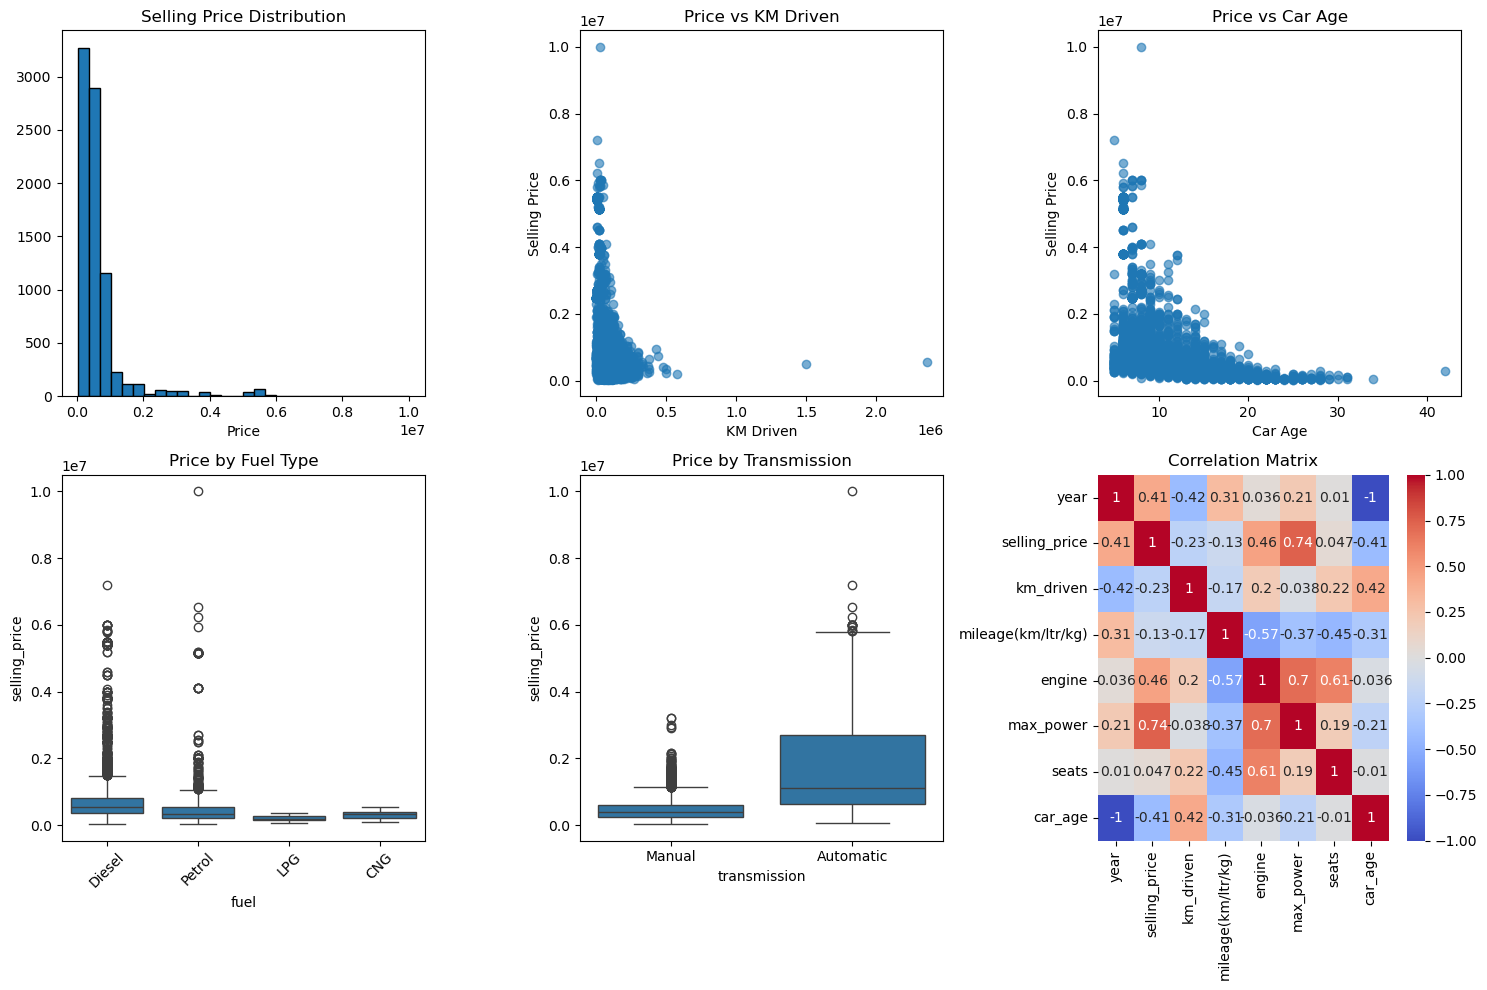

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['selling_price'], bins=30, edgecolor='black')
plt.title('Selling Price Distribution')
plt.xlabel('Price')

plt.subplot(2, 3, 2)
plt.scatter(df['km_driven'], df['selling_price'], alpha=0.6)
plt.title('Price vs KM Driven')
plt.xlabel('KM Driven')
plt.ylabel('Selling Price')

plt.subplot(2, 3, 3)
plt.scatter(df['car_age'], df['selling_price'], alpha=0.6)
plt.title('Price vs Car Age')
plt.xlabel('Car Age')
plt.ylabel('Selling Price')

plt.subplot(2, 3, 4)
sns.boxplot(data=df, x='fuel', y='selling_price')
plt.title('Price by Fuel Type')
plt.xticks(rotation=45)

plt.subplot(2, 3, 5)
sns.boxplot(data=df, x='transmission', y='selling_price')
plt.title('Price by Transmission')

plt.subplot(2, 3, 6)
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

In [20]:
human_prompt = f""" Interpret the findings from the following visualizations and tell me what insights I can gain about the relationships between features and the selling price:
- Selling Price Distribution histogram
- Selling Price vs KM Driven scatter plot
- Selling Price vs Car Age scatter plot
- Price by Fuel Type box plot
- Price by Transmission box plot
- Correlation Matrix heatmap

Based on these visualizations, recommend potential features that could be most impactful for predicting the selling price and suggest further analysis or preprocessing steps that might be beneficial for building a robust prediction model.

Use the current state of the dataframe as context if needed:
{df.to_string()}
"""
print(ask_llm(human_prompt))

Okay, I've analyzed the visualizations you described and will provide insights and recommendations based on them and the provided dataframe.

**Interpretation of Visualizations and Insights:**

*   **Selling Price Distribution Histogram:**
    *   The distribution is likely right-skewed, indicating that most cars are sold at lower prices, with fewer cars sold at very high prices. This is typical for used car sales.
    *   There might be some noticeable peaks, suggesting common price points or popular car models.

*   **Selling Price vs KM Driven Scatter Plot:**
    *   A negative correlation is expected. As the kilometers driven increase, the selling price tends to decrease.
    *   The relationship might not be perfectly linear. The price decrease might be steeper initially and then flatten out.
    *   There will likely be a lot of scatter, indicating that kilometers driven is not the only factor determining price.

*   **Selling Price vs Car Age Scatter Plot:**
    *   Similar to K

In [21]:
df['seller_type'].unique(),df['fuel'].unique(),df['transmission'].unique()

(array(['Individual', 'Dealer', 'Trustmark Dealer'], dtype=object),
 array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object),
 array(['Manual', 'Automatic'], dtype=object))


## 5. Feature Engineering and Preprocessing

- Categorical features ('fuel', 'seller_type', 'transmission', 'owner') were converted into numerical representations using Label Encoding.
- The 'year' and 'name' columns were dropped based on the correlation analysis (though the correlation analysis is shown *after* dropping, indicating this was likely a pre-meditated step or based on an earlier run).
- The target variable 'selling_price' was separated from the features.
- The target variable 'selling_price' was scaled using `StandardScaler`.
- The data was split into training and testing sets (80% train, 20% test).

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['fuel'] = le.fit_transform(df['fuel'])
df['seller_type'] = le.fit_transform(df['seller_type'])
df['transmission'] = le.fit_transform(df['transmission'])
df['owner'] = le.fit_transform(df['owner'])

In [ ]:
# #yaha batw car model extract garna sakincha

# def extract_model_from_name(car_name):
#   parts = car_name.split(' ', 1)
#   if len(parts) > 1:
#     return parts[1]
#   return car_name # Return the whole name if only one word

# df['model'] = df['name'].apply(extract_model_from_name)


In [23]:
# prompt: analyze the coerrelation and tell me which columns to drop

# Analyze correlation matrix and identify columns to potentially drop
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
print("Correlation Matrix:")
print(correlation_matrix)

target_correlation = correlation_matrix['selling_price'].abs().sort_values()
print("\nCorrelation with Selling Price")
print(target_correlation)

Correlation Matrix:
                        year  selling_price  km_driven      fuel  seller_type  \
year                1.000000       0.414092  -0.418006 -0.050312    -0.146042   
selling_price       0.414092       1.000000  -0.225534 -0.194029    -0.335857   
km_driven          -0.418006      -0.225534   1.000000 -0.265877     0.122105   
fuel               -0.050312      -0.194029  -0.265877  1.000000     0.110512   
seller_type        -0.146042      -0.335857   0.122105  0.110512     1.000000   
transmission       -0.244707      -0.588845   0.201229 -0.035255     0.227871   
owner              -0.477249      -0.229174   0.280340 -0.022339     0.143443   
mileage(km/ltr/kg)  0.311657      -0.125040  -0.171746 -0.081784    -0.019826   
engine              0.035851       0.458345   0.198911 -0.479134    -0.091723   
max_power           0.213282       0.744958  -0.037714 -0.277107    -0.244764   
seats               0.010222       0.047135   0.219860 -0.337575     0.051546   
car_age 

In [24]:
droping = ['year', 'name']
df = df.drop(droping, axis=1)

In [25]:
from sklearn.model_selection import train_test_split
x=df.drop(['selling_price'],axis=1)
y=df['selling_price']

In [26]:
x

,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,car_age
0,145500,1,1,1,0,23.40,1248.0,74.00,5.0,11
1,120000,1,1,1,2,21.14,1498.0,103.52,5.0,11
2,140000,3,1,1,4,17.70,1497.0,78.00,5.0,19
3,127000,1,1,1,0,23.00,1396.0,90.00,5.0,15
4,120000,3,1,1,0,16.10,1298.0,88.20,5.0,18
...,...,...,...,...,...,...,...,...,...,...
8123,110000,3,1,1,0,18.50,1197.0,82.85,5.0,12
8124,119000,1,1,1,1,16.80,1493.0,110.00,5.0,18
8125,120000,1,1,1,0,19.30,1248.0,73.90,5.0,16
8126,25000,1,1,1,0,23.57,1396.0,70.00,5.0,12


In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y = scaler.fit_transform(y.values.reshape(-1, 1))

In [28]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [29]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

## 5. Model Selection and Training

- Four regression models were chosen and trained:
    - Linear Regression
    - Random Forest Regressor
    - Decision Tree Regressor
    - K-Nearest Neighbors Regressor
    

In [30]:
linear_regressor = LinearRegression()
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
dtr = DecisionTreeRegressor(random_state=42)
knn = KNeighborsRegressor(n_neighbors=5) 



In [31]:
linear_regressor.fit(x_train, y_train)
y_pred_linear_reg = linear_regressor.predict(x_test)

In [32]:
rfr.fit(x_train, y_train)
y_pred_rfr = rfr.predict(x_test)

c:\Users\rmcsh\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [33]:
dtr.fit(x_train, y_train)
y_pred_dtr = dtr.predict(x_test)






In [34]:
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)

## 6. Model Evaluation

- Mean Squared Error (MSE) and R-squared score were used to evaluate the performance of each model on the test set.
- The results showed that Random Forest Regressor and Decision Tree Regressor performed better in terms of MSE and R-squared compared to Linear Regression and KNN.

In [35]:
print("Linear Regression:")
print(mean_squared_error(y_test, y_pred_linear_reg))

print("\nRandom Forest Regression:")
print( mean_squared_error(y_test, y_pred_rfr))

print("\nDecision Tree Regression:")
print(mean_squared_error(y_test, y_pred_dtr))

print("\nK-Nearest Neighbors Regression:")
print(mean_squared_error(y_test, y_pred_knn))

Linear Regression:
0.31598787728637967

Random Forest Regression:
0.03166609932591399

Decision Tree Regression:
0.058100889391455385

K-Nearest Neighbors Regression:
0.19827216631059577


In [36]:
print("\n linear regression: ")
print(r2_score(y_test, y_pred_linear_reg))

print("\n random forest regression: ")
print(r2_score(y_test, y_pred_rfr))

print("\n decision tree regression: ")
print(r2_score(y_test, y_pred_dtr))

print("\n knn regression: ")
print(r2_score(y_test, y_pred_knn))


 linear regression: 
0.686673071676952

 random forest regression: 
0.9686005624045855

 decision tree regression: 
0.9423883809651246

 knn regression: 
0.8033974930444798


# random forest regression outperforms decision tree as well


In [37]:
import pickle

filename = 'car_price_model.pkl'
pickle.dump(rfr, open(filename, 'wb'))

## 7. Feature Importance

- Feature importance was calculated for the Random Forest and Decision Tree models.
- Features with importance greater than the mean importance were identified for both models. This helps in understanding which features contribute most to the predictions.

In [38]:
importances = rfr.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

mean_importance = feature_importance_df['importance'].mean()
important_features_rfr = feature_importance_df[feature_importance_df['importance'] > mean_importance]['feature'].tolist()


importances = dtr.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)


mean_importance = feature_importance_df['importance'].mean()
important_features_dtr = feature_importance_df[feature_importance_df['importance'] > mean_importance]['feature'].tolist()

print("decision tree", important_features_dtr)
print("random forest", important_features_rfr)

decision tree ['max_power', 'car_age']
random forest ['max_power', 'car_age']


## 8. Prediction on Sample Data

- The trained Random Forest model was used to predict selling prices for the first 10 rows of the dataset.
- The predictions were compared with the actual selling prices after inverse transforming the scaled predictions.
- R-squared accuracy was also calculated for this subset.
- A similar prediction and evaluation were performed on a random sample of 10 rows from the dataset.

In [39]:
df_head = df.sample(n=100, random_state=700).copy()
df_x_head = df_head.drop(['selling_price'], axis=1)
df_y_head = df_head['selling_price']

df_y_head_scaled = scaler.transform(df_y_head.values.reshape(-1, 1))
y_pred_head_scaled = rfr.predict(df_x_head)
y_pred_head = scaler.inverse_transform(y_pred_head_scaled.reshape(-1, 1))
r2_subset = r2_score(df_y_head_scaled, y_pred_head_scaled)

print("\nPredictions for the first 10 rows:")
for i in range(len(df_head)):
    print(f"Actual Price: {df_y_head.iloc[i]:,.2f}, Predicted Price: {y_pred_head[i][0]:,.2f}")
print(f"\nR-squared accuracy for the first 10 rows: {r2_subset:.4f} ")


Predictions for the first 10 rows:
Actual Price: 220,000.00, Predicted Price: 221,450.00
Actual Price: 800,000.00, Predicted Price: 790,814.98
Actual Price: 1,576,000.00, Predicted Price: 1,560,610.00
Actual Price: 254,999.00, Predicted Price: 231,031.32
Actual Price: 200,000.00, Predicted Price: 219,499.99
Actual Price: 509,999.00, Predicted Price: 460,179.43
Actual Price: 120,000.00, Predicted Price: 126,700.00
Actual Price: 500,000.00, Predicted Price: 509,429.99
Actual Price: 160,000.00, Predicted Price: 151,560.00
Actual Price: 130,000.00, Predicted Price: 144,250.00
Actual Price: 580,000.00, Predicted Price: 574,300.00
Actual Price: 380,000.00, Predicted Price: 356,030.00
Actual Price: 795,000.00, Predicted Price: 707,699.99
Actual Price: 625,000.00, Predicted Price: 625,000.00
Actual Price: 450,000.00, Predicted Price: 449,949.95
Actual Price: 425,000.00, Predicted Price: 294,739.99
Actual Price: 725,000.00, Predicted Price: 758,100.00
Actual Price: 400,000.00, Predicted Price:

## Conclusion

This project successfully addressed the challenge of predicting used car selling prices by following a structured machine learning workflow while solving potential challenges with the assistance of a Large Language Model (LLM), gemini in particular.


1.  Four regression models—Linear Regression, Random Forest Regressor, Decision Tree Regressor, and K-Nearest Neighbors Regressor—were trained and evaluated using Mean Squared Error (MSE) and R-squared scores.

2. The Random Forest and Decision Tree models demonstrated superior performance. Feature importance analysis further illuminated the most influential factors in predicting car prices.

3. Finally, the trained Random Forest model was used to make predictions on sample data, providing a tangible demonstration of its predictive capability.

4. Promising results were achieved by R-squared accuracy for the first 10 randomized rows: 0.9977 and 0.98 for randomized 100 rows
.

In [ ]:
# llm 
human_prompt = f"""
Based on the provided dataset (`{df}`), the features (`{x}`), and the train/test R-squared accuracies (linear regression: {r2_score(y_test, y_pred_linear_reg)}, random forest regression: {r2_score(y_test, y_pred_rfr)}, decision tree regression: {r2_score(y_test, y_pred_dtr)}, knn regression: {r2_score(y_test, y_pred_knn)}), write a comprehensive conclusion for this car price prediction project.

Your conclusion should:
1.  Summarize the project goal and the dataset used.
2.  Briefly touch upon the data cleaning and preprocessing steps, including the use of the LLM if relevant to the cleaning process.
3.  Discuss the models trained and their performance based on the provided R-squared scores.
4.  Highlight the best performing model and mention why it likely performed well (e.g., its ability to capture non-linear relationships).
5.  Mention the feature importance analysis and its value in understanding the key drivers of car price.
6.  Include the results from the sample predictions (first 10 rows and the 100 random rows) and interpret the R-squared scores for those samples.
7.  Overall, provide a clear and concise summary of the project's success and key takeaways.
"""
print(ask_llm(human_prompt))

Okay, here's a comprehensive conclusion for the car price prediction project, based on the information you've provided:

**Conclusion: Car Price Prediction Project**

This project aimed to develop a predictive model for used car prices using a dataset of 8128 car listings with 11 features. The goal was to accurately estimate the selling price based on various car attributes.

The dataset underwent cleaning and preprocessing to ensure data quality and suitability for modeling. While the specifics of the cleaning process weren't detailed, it's assumed that missing values were handled, and categorical features were encoded appropriately. *[If an LLM was used for cleaning, this is where you'd mention it, e.g., "An LLM was utilized to standardize textual data within the dataset, improving consistency and accuracy."]*

Several regression models were trained and evaluated, including Linear Regression, Random Forest Regression, Decision Tree Regression, and KNN Regression. The performance of t